## Recreation of Terry's Notebook with NgSpice

In this experiment we are going to recreate Terry's notebook with NgSpice simulation backend in Google Colab.

## Step 1: Set up Python3 and NgSpice

In [2]:
!pip install nengo
!pip install pyspice
!sudo add-apt-repository ppa:kicad/kicad-5.1-releases -y
!sudo apt-get update
!sudo apt-get install libngspice-kicad


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/kicad/kicad-5.1-releases/ubu

In [3]:
# Load the library file

from google.colab import files
uploaded =  files.upload() #upload the 180nm.lib file here

Saving 180nm.lib to 180nm.lib


In [4]:

%matplotlib inline
import matplotlib.pyplot as plt

# check if ngspice can be found from python
from ctypes.util import find_library
ngspice_lib_filename = find_library('libngspice')
print(ngspice_lib_filename) ## if the result is none, make sure that libngspice is installed

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
ngspice = NgSpiceShared.new_instance()
print(ngspice.exec_command('version -f'))

import nengo
import numpy as np

None
2020-12-29 20:48:44,583 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - spinit was not found
2020-12-29 20:48:44,584 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - Note: can't find init file.
******
** ngspice-30 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Wed Feb 27 13:04:52 UTC 2019
**
** CIDER 1.b1 (CODECS simulator) included
** XSPICE extensions included
** Relevant compilation options (refer to user's manual):
** OpenMP multithreading for BSIM3, BSIM4 enabled
** X11 interface not compiled into ngspice
**
******


## Step 2: Define a single neuron

Let's start with the subcircuit of a single neuron. We are going to use voltage amplifier leaky-integrate and fire neurons discussed in Section 3.3 of Indiveri et al.(May 2011).

In [5]:
neuron_model = '''
.subckt my_neuron Vmem out cvar=100p vsupply=1.8 vtau=0.4 vthr=0.2 vb=1

V1 Vdd 0 {vsupply}
V6 Vtau 0 {vtau}
V2 Vthr 0 {vthr}
V3 Vb1 0 {vb}
C1 Vmem 0 {cvar}


M5 N001 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M6 N002 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M8 N001 Vmem N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M9 N002 Vthr N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M10 N004 Vb1 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
Mreset Vmem out 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M7 N003 N002 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M18 out N003 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M19 N003 N002 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M20 out N003 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
Mleak Vmem Vtau 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2


.ends my_neuron
'''

Create the neuron's netlist

In [6]:
def create_neuron_netlist(N):
    # N is the number of neurons
    netlist = ''
    for i in range(N):
        netlist += 'x'+str(i)+' Vmem'+str(i)+' out'+str(i)+' my_neuron vsupply={vsource} cvar=150p vthr=0.25 \n'
        netlist += 'Rload'+str(i)+' out'+str(i)+ ' 0 100k\n'
    return netlist

netlist_neurons = create_neuron_netlist(1)

## Step 3: Generate the input

Now, let's generate some input and see what it does. We are going to use the WhiteSignal that Terry used; however,we are going to shink the signal in amplitude (since this would be a current signal in the circuit) and also increase the frequency of the signal.

In [7]:
stim = nengo.processes.WhiteSignal(period=10, high=5, seed=1).run(1, dt=0.001)
input_signal = [[i*1e-6, J[0]*10e-6] for i, J in enumerate(stim)] #scaling

Lets convert this signal to a current source.

In [8]:
def pwl_conv(signal):
    # signal should be a list of lists where wach sublist has this form [time_value, current_value]
    pwl_string = ''
    for i in signal:
        pwl_string += str(i[0]) + ' ' + str(i[1]) + ' '
    return pwl_string

## Step 4: Generate remaining parts of the Spice Netlist 

In [9]:
netlist_input = 'Iin0 Vdd Vmem0 PWL(' + pwl_conv(input_signal) +')\n' # Converting the input to a current source

In [10]:
## other setup parameters
args= {}
args['simulation_time'] = '1m'
args['simulation_step'] = '1u'
args['simulation_lib']  = '180nm.lib'


netlist_top= '''*Sample SPICE file
.include {simulation_lib}
.option scale=1u
.OPTIONS ABSTOL=1N VNTOL=1M.
.options savecurrents
.tran {simulation_step} {simulation_time} UIC
'''.format(**args)

netlist_bottom = '''
.end'''

In [11]:
## define the sources
netlist_source = '''
.param vsource = 1.8
Vdd Vdd 0 {vsource}
'''

In [12]:
netlist = netlist_top + netlist_source + neuron_model + netlist_input+ netlist_neurons+ netlist_bottom

## Step 5: Simulate the netlist

In [13]:
def simulate(circuit):
    ngspice.load_circuit(circuit)
    ngspice.run()
    print('Plots:', ngspice.plot_names)
    plot = ngspice.plot(simulation=None, plot_name=ngspice.last_plot)
    return plot

Great! We have a system that does some sort of nonlinearity. Now let's create a feedforward system with a bunch of neurons and see if the system can be used for approximating a function. 

## Step 6: Function approximation with a feedforward network

In [15]:
N = 50  # how many neurons there are
E = np.random.normal(size=(N, 1))
B = np.random.normal(size=(N))*0.1
netlist_neurons = create_neuron_netlist(N)

*Now let's feed that same stimulus to all the neurons and see how they behave.*

In [16]:
def create_neuron_current_netlist(E,B,stim,N):
    # take the A matrix and the number of neurons
    # refactor 
    netlist_input='\n'
    signal = np.zeros((len(stim), N))
    for i, J in enumerate(stim):
        Js = np.dot(E, J)
        for k, JJ in enumerate(Js):
            signal[i][k] = JJ+B[k]
    
    for k in range(N):
        input_signal = [[i*1e-6, J*10e-6] for i, J in enumerate(signal[:,k])]
        netlist_input += 'Iin'+str(k)+' Vdd Vmem'+str(k)+' PWL(' + pwl_conv(input_signal) +')\n\n'
    
    return netlist_input

netlist_inputs = create_neuron_current_netlist(E,B,stim,N)

In [17]:
netlist = netlist_top + netlist_source + neuron_model + netlist_inputs+ netlist_neurons+ netlist_bottom
out=simulate(netlist)

2020-12-29 20:49:54,776 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin49: no DC value, transient time 0 value used
2020-12-29 20:49:54,777 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin48: no DC value, transient time 0 value used
2020-12-29 20:49:54,778 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin47: no DC value, transient time 0 value used
2020-12-29 20:49:54,780 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin46: no DC value, transient time 0 value used
2020-12-29 20:49:54,781 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin45: no DC value, transient time 0 value used
2020-12-29 20:49:54,782 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin44: no DC value, transient time 0 value used
2020-12-29 20:49:54,783 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin43

So it seems we have some output from the ensemble. Lets convert this output to get the A matrix

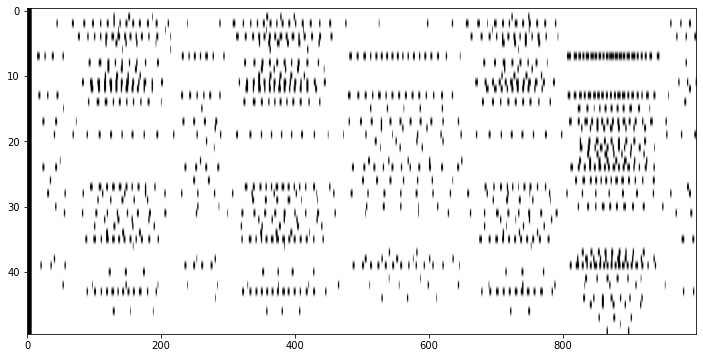

In [18]:
def extract_A_matrix(result, N, stim):
    t = np.linspace(min(out['time']._data), max(out['time']._data), len(stim))
    temp_time = out['time']._data
    inpterpolated_result = np.zeros((len(stim), N))
    A = np.zeros((len(stim), N))
    for j in range(N):
        temp_str = '@rload'+str(j)+'[i]'
        temp_out = result[temp_str]._data
        inpterpolated_result[:,j] = np.interp(t, temp_time, temp_out)
        A[:,j] = inpterpolated_result[:,j] > max(inpterpolated_result[:,j])/2
    return A
A_from_spice = extract_A_matrix(out, N, stim)
plt.figure(figsize=(12,6))
plt.imshow(A_from_spice.T, aspect='auto', cmap='gray_r')
plt.show()

Cool! This is similar to the A matrix we got from Terry's notebook. We can also calculate the D matrix from this output and approximate the y(t)=x(t) function.

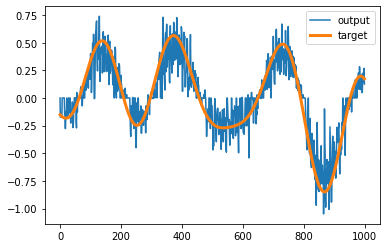

RMSE: [0.14131726]


In [19]:
target = stim
D_from_spice, info = nengo.solvers.LstsqL2()(A_from_spice, target)

plt.plot(A_from_spice.dot(D_from_spice), label='output')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

*With spiking neuron models, it's very common to have a low-pass filter (i.e. a synapse) after the spike. Let's see what our output looks like with a low-pass filter applied.*

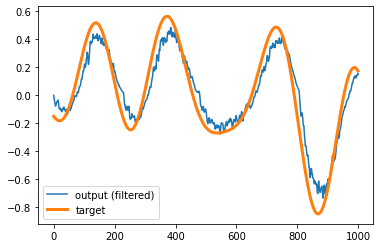

In [20]:
filt = nengo.synapses.Lowpass(0.01) #need to implement synapses in circuit
plt.plot(filt.filt(A_from_spice.dot(D_from_spice)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()